In [80]:
import keras
import netCDF4
import pandas
import sklearn.preprocessing
import sklearn.model_selection
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
ds = netCDF4.Dataset('http://uhslc.soest.hawaii.edu/thredds/dodsC/uhslc/rqh/OS_UH-RQH260A_20160323_R')

In [22]:
lat, lon = ds.variables['latitude'][0], ds.variables['longitude'][0]
lat, lon

(35.182999, -75.75)

In [9]:
h = ds.variables['sea_surface_height_above_reference_level'][:, 0, 0, 0]
t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)

In [73]:
df = pandas.DataFrame(dict(t=t, h=h))
df = df.set_index(t).dropna()
df['year'] = [x.year for x in df.index]

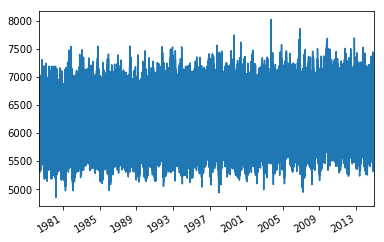

In [75]:
df['h'].plot()

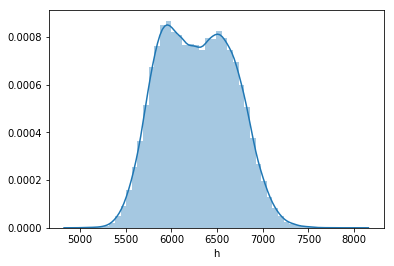

In [66]:
import seaborn
_ = seaborn.distplot(df['h'].tail(n=100000))


In [155]:
# LTSM expects data to be scaled
N = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
values = df['h'].values[:, np.newaxis]
# transform
N.fit(values)
print("min", N.data_min_, "range", N.data_range_)
scaled = N.transform(values)
df['h_scaled'] = np.squeeze(scaled)

min [ 4855.] range [ 3175.]


In [176]:
year_train, year_test, year_validate = np.random.choice(list(set(df.year)), 3)
year_train, year_test, year_validate = (2000, 2001, 2002)

In [188]:
def make_dataset(all_df, year):
    df = all_df.ix[all_df.year == year]
    df_lookback = pandas.DataFrame(data=dict(
        t=df['t'].iloc[:-1],
        x=df['h_scaled'].values[:-1], 
        y=df['h_scaled'].values[1:]
    ))
    return df_lookback.set_index('t')


In [189]:
df_train = make_dataset(df, year_train)
df_test = make_dataset(df, year_test)
df_validate = make_dataset(df, year_validate)
df_train.head()

,x,y
t,,
2000-01-01 00:00:00.000000,0.291024,0.235276
2000-01-01 01:00:00.000288,0.235276,0.221102
2000-01-01 01:59:59.999712,0.221102,0.243465
2000-01-01 03:00:00.000000,0.243465,0.291654
2000-01-01 04:00:00.000288,0.291654,0.356535


In [190]:
look_back = 1
model = keras.models.Sequential()
layer = keras.layers.LSTM(4, input_shape=(1, look_back))
model.add(layer)
layer = keras.layers.Dense(1)
model.add(layer)
model.compile(loss='mean_squared_error', optimizer='adam')

In [205]:
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_6 (LSTM)                    (None, 4)             96          lstm_input_6[0][0]               
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 1)             5           lstm_6[0][0]                     
Total params: 101
Trainable params: 101
Non-trainable params: 0
____________________________________________________________________________________________________


array([[[ 0.29102362]],

       [[ 0.23527559]],

       [[ 0.22110236]],

       ..., 
       [[ 0.31590551]],

       [[ 0.25385827]],

       [[ 0.21133858]]])

In [ ]:
X = df_train['x'].values[:, np.newaxis, np.newaxis]
Y = df_train['y'].values
print(X.shape, Y.shape)
model.fit(X, Y, nb_epoch=100, batch_size=1, verbose=2)

(8412, 1, 1) (8412,)
Epoch 1/100


In [203]:
import keras.utils.visualize_util
keras.utils.visualize_util.plot(model)

In [204]:
%%html
<img src="model.png">